This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xradar furuno backend

In this example, we read scn/scnx (furuno) data files using the xradar `furuno` xarray backend.

In [1]:
import glob
import gzip
import io
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import xradar as xd
import datatree as xt
import xarray as xr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

## Load furuno scn Data

Data provided by University of Graz, Austria.

In [2]:
fpath = "furuno/0080_20210730_160000_01_02.scn.gz"
f = wrl.util.get_wradlib_data_file(fpath)
vol = xd.io.open_furuno_datatree(f, reindex_angle=False)

### Inspect RadarVolume

In [3]:
display(vol)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2021-07-30T16:00:00Z'
│       time_coverage_end    <U20 '2021-07-30T16:00:14Z'
│       longitude            float64 15.45
│       altitude             float64 407.9
│       latitude             float64 47.08
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 1376, range: 602)
        Coordinates:
          * azimuth            (azimuth) float32 0.21 0.47 0.74 ... 359.4 359.7 359.9
            elevation          (azimuth) float32 ...
          * range              (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
            time               (azimuth) datetime64[ns] 2021-07-30T16:00:06.277723500...
            longitude          float64 ...
            latitude           float64 ...
            altitude           float64 ...
        Data variables: (12/14)
            RATE               (azimuth, range) float32 ...
            DBZH               (azimuth, range) float32 ...
            VRADH              (azimuth, range) float32 ...
            ZDR                (azimuth, range) float32 ...
            KDP                (azimuth, range) float32 ...
            PHIDP              (azimuth, range) float32 ...
            ...                 ...
            QUAL               (azimuth, range) uint16 ...
            sweep_mode         <U20 ...
            sweep_number       int64 ...
            prt_mode           <U7 ...
            follow_mode        <U7 ...
            sweep_fixed_angle  float64 ...

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [4]:
vol.root

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2021-07-30T16:00:00Z'
│       time_coverage_end    <U20 '2021-07-30T16:00:14Z'
│       longitude            float64 15.45
│       altitude             float64 407.9
│       latitude             float64 47.08
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 1376, range: 602)
        Coordinates:
          * azimuth            (azimuth) float32 0.21 0.47 0.74 ... 359.4 359.7 359.9
            elevation          (azimuth) float32 ...
          * range              (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
            time               (azimuth) datetime64[ns] 2021-07-30T16:00:06.277723500...
            longitude          float64 ...
            latitude           float64 ...
            altitude           float64 ...
        Data variables: (12/14)
            RATE               (azimuth, range) float32 ...
            DBZH               (azimuth, range) float32 ...
            VRADH              (azimuth, range) float32 ...
            ZDR                (azimuth, range) float32 ...
            KDP                (azimuth, range) float32 ...
            PHIDP              (azimuth, range) float32 ...
            ...                 ...
            QUAL               (azimuth, range) uint16 ...
            sweep_mode         <U20 ...
            sweep_number       int64 ...
            prt_mode           <U7 ...
            follow_mode        <U7 ...
            sweep_fixed_angle  float64 ...

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [5]:
display(vol["sweep_0"])

DataTree('sweep_0', parent="root")
    Dimensions:            (azimuth: 1376, range: 602)
    Coordinates:
      * azimuth            (azimuth) float32 0.21 0.47 0.74 ... 359.4 359.7 359.9
        elevation          (azimuth) float32 ...
      * range              (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
        time               (azimuth) datetime64[ns] 2021-07-30T16:00:06.277723500...
        longitude          float64 ...
        latitude           float64 ...
        altitude           float64 ...
    Data variables: (12/14)
        RATE               (azimuth, range) float32 ...
        DBZH               (azimuth, range) float32 ...
        VRADH              (azimuth, range) float32 ...
        ZDR                (azimuth, range) float32 ...
        KDP                (azimuth, range) float32 ...
        PHIDP              (azimuth, range) float32 ...
        ...                 ...
        QUAL               (azimuth, range) uint16 ...
        sweep_mode         <U20 ...
        sweep_number       int64 ...
        prt_mode           <U7 ...
        follow_mode        <U7 ...
        sweep_fixed_angle  float64 ...

### Georeferencing

In [6]:
swp = vol["sweep_0"].ds.copy()
swp = swp.assign_coords(sweep_mode=swp.sweep_mode)
swp = swp.wrl.georef.georeference()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset.

In [7]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 1376, range: 602)>
[828352 values with dtype=float32]
Coordinates: (12/15)
  * azimuth      (azimuth) float32 0.21 0.47 0.74 1.0 ... 359.4 359.7 359.9
    elevation    (azimuth) float32 7.8 7.8 7.8 7.8 7.8 ... 7.8 7.8 7.8 7.8 7.8
  * range        (range) float32 25.0 75.0 125.0 ... 3.002e+04 3.008e+04
    time         (azimuth) datetime64[ns] 2021-07-30T16:00:06.277723500 ... 2...
    sweep_mode   <U20 'azimuth_surveillance'
    longitude    float64 15.45
    ...           ...
    y            (azimuth, range) float32 24.77 74.3 ... 2.973e+04 2.978e+04
    z            (azimuth, range) float32 411.0 418.0 ... 4.535e+03 4.542e+03
    gr           (azimuth, range) float32 24.77 74.3 ... 2.973e+04 2.978e+04
    rays         (azimuth, range) float32 0.21 0.21 0.21 ... 359.9 359.9 359.9
    bins         (azimuth, range) float32 25.0 75.0 ... 3.002e+04 3.008e+04
    spatial_ref  int64 0
Attributes:
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    coordinates:    elevation azimuth range latitude longitude altitude time ...

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

For more details on plotting radar data see under [Visualization](../../plotting.ipynb).

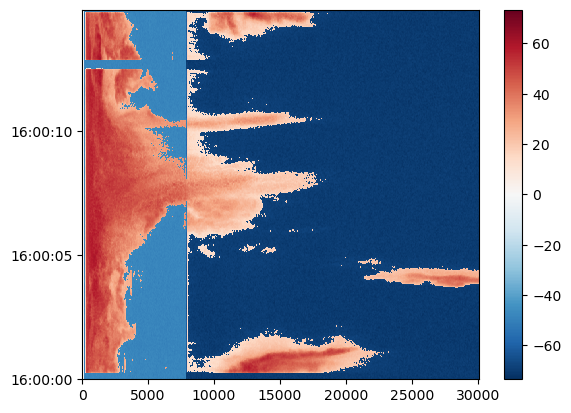

In [8]:
swp.DBZH.sortby("time").plot(x="range", y="time", add_labels=False)

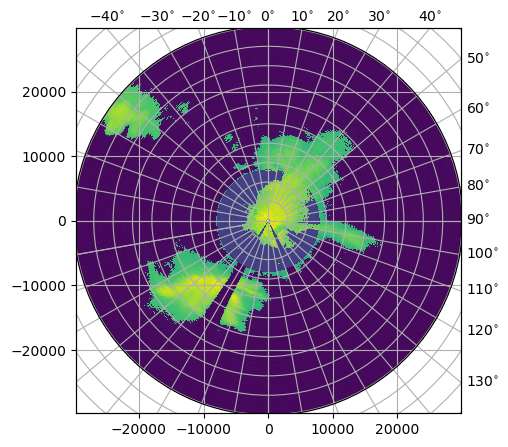

In [9]:
fig = plt.figure(figsize=(5, 5))
pm = swp.DBZH.wrl.vis.plot(crs={"latmin": 3e3}, fig=fig)

### Use `xr.open_dataset` to retrieve explicit group

## Load furuno scnx Data

Data provided by GFZ German Research Centre for Geosciences.

In [10]:
fpath = "furuno/2006_20220324_000000_000.scnx.gz"
f = wrl.util.get_wradlib_data_file(fpath)
vol = xd.io.open_furuno_datatree(f, reindex_angle=False)

### Inspect RadarVolume

In [11]:
display(vol)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2022-03-24T00:00:01Z'
│       time_coverage_end    <U20 '2022-03-24T00:00:28Z'
│       longitude            float64 13.24
│       altitude             float64 38.0
│       latitude             float64 53.55
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 722, range: 936)
        Coordinates:
          * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
            elevation          (azimuth) float32 ...
          * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
            time               (azimuth) datetime64[ns] 2022-03-24T00:00:17.656439500...
            longitude          float64 ...
            latitude           float64 ...
            altitude           float64 ...
        Data variables: (12/14)
            RATE               (azimuth, range) float32 ...
            DBZH               (azimuth, range) float32 ...
            VRADH              (azimuth, range) float32 ...
            ZDR                (azimuth, range) float32 ...
            KDP                (azimuth, range) float32 ...
            PHIDP              (azimuth, range) float32 ...
            ...                 ...
            QUAL               (azimuth, range) uint16 ...
            sweep_mode         <U20 ...
            sweep_number       int64 ...
            prt_mode           <U7 ...
            follow_mode        <U7 ...
            sweep_fixed_angle  float64 ...

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [12]:
vol.root

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2022-03-24T00:00:01Z'
│       time_coverage_end    <U20 '2022-03-24T00:00:28Z'
│       longitude            float64 13.24
│       altitude             float64 38.0
│       latitude             float64 53.55
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
└── DataTree('sweep_0')
        Dimensions:            (azimuth: 722, range: 936)
        Coordinates:
          * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
            elevation          (azimuth) float32 ...
          * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
            time               (azimuth) datetime64[ns] 2022-03-24T00:00:17.656439500...
            longitude          float64 ...
            latitude           float64 ...
            altitude           float64 ...
        Data variables: (12/14)
            RATE               (azimuth, range) float32 ...
            DBZH               (azimuth, range) float32 ...
            VRADH              (azimuth, range) float32 ...
            ZDR                (azimuth, range) float32 ...
            KDP                (azimuth, range) float32 ...
            PHIDP              (azimuth, range) float32 ...
            ...                 ...
            QUAL               (azimuth, range) uint16 ...
            sweep_mode         <U20 ...
            sweep_number       int64 ...
            prt_mode           <U7 ...
            follow_mode        <U7 ...
            sweep_fixed_angle  float64 ...

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [13]:
display(vol["sweep_0"])

DataTree('sweep_0', parent="root")
    Dimensions:            (azimuth: 722, range: 936)
    Coordinates:
      * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
        elevation          (azimuth) float32 ...
      * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
        time               (azimuth) datetime64[ns] 2022-03-24T00:00:17.656439500...
        longitude          float64 ...
        latitude           float64 ...
        altitude           float64 ...
    Data variables: (12/14)
        RATE               (azimuth, range) float32 ...
        DBZH               (azimuth, range) float32 ...
        VRADH              (azimuth, range) float32 ...
        ZDR                (azimuth, range) float32 ...
        KDP                (azimuth, range) float32 ...
        PHIDP              (azimuth, range) float32 ...
        ...                 ...
        QUAL               (azimuth, range) uint16 ...
        sweep_mode         <U20 ...
        sweep_number       int64 ...
        prt_mode           <U7 ...
        follow_mode        <U7 ...
        sweep_fixed_angle  float64 ...

### Georeferencing

In [14]:
swp = vol["sweep_0"].ds.copy()
swp = swp.assign_coords(sweep_mode=swp.sweep_mode)
swp = swp.wrl.georef.georeference()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset. 

In [15]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 722, range: 936)>
[675792 values with dtype=float32]
Coordinates: (12/15)
  * azimuth      (azimuth) float32 0.19 0.68 1.16 1.69 ... 358.7 359.2 359.7
    elevation    (azimuth) float32 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5 0.5
  * range        (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
    time         (azimuth) datetime64[ns] 2022-03-24T00:00:17.656439500 ... 2...
    sweep_mode   <U20 'azimuth_surveillance'
    longitude    float64 13.24
    ...           ...
    y            (azimuth, range) float32 37.5 112.5 ... 7.008e+04 7.015e+04
    z            (azimuth, range) float32 38.0 39.0 39.0 ... 937.0 939.0 940.0
    gr           (azimuth, range) float32 37.53 112.5 ... 7.008e+04 7.015e+04
    rays         (azimuth, range) float32 0.19 0.19 0.19 ... 359.7 359.7 359.7
    bins         (azimuth, range) float32 37.5 112.5 ... 7.009e+04 7.016e+04
    spatial_ref  int64 0
Attributes:
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    coordinates:    elevation azimuth range latitude longitude altitude time ...

### Create simple plot

Currently the data dynamic range is left as read from the file. That way the difference between shortpulse and longpulse can be clearly seen.

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

For more details on plotting radar data see under [Visualization](../../plotting.ipynb).

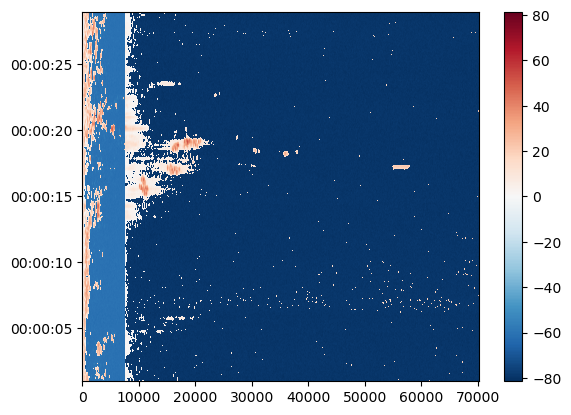

In [16]:
swp.DBZH.sortby("time").plot(x="range", y="time", add_labels=False)

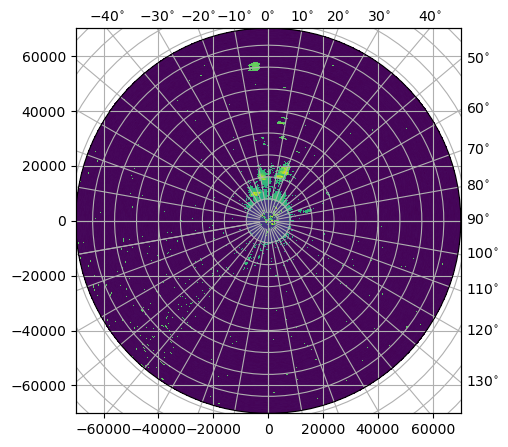

In [17]:
fig = plt.figure(figsize=(5, 5))
pm = swp.DBZH.wrl.vis.plot(crs={"latmin": 3e3}, fig=fig)

## More Furuno loading mechanisms

### Use `xr.open_dataset` to retrieve explicit group

In [18]:
swp_b = xr.open_dataset(f, engine="furuno", backend_kwargs=dict(reindex_angle=False))
display(swp_b)

<xarray.Dataset>
Dimensions:            (azimuth: 722, range: 936)
Coordinates:
  * azimuth            (azimuth) float32 0.19 0.68 1.16 ... 358.7 359.2 359.7
    elevation          (azimuth) float32 ...
  * range              (range) float32 37.5 112.5 187.5 ... 7.009e+04 7.016e+04
    time               (azimuth) datetime64[ns] ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables: (12/14)
    RATE               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    ...                 ...
    QUAL               (azimuth, range) uint16 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...